In [1]:
# !pip install datasets transformers evaluate scikit-learn -q

import pandas as pd
import torch
from datasets import load_dataset, DatasetDict, Features, ClassLabel, Image
from transformers import AutoImageProcessor
from torchvision import transforms
from PIL import Image as PILImage # Use PILImage to avoid name conflict
import os

# --- 1. Define All File Paths ---
BASE_PATH = "/kaggle/input/food41/"
IMAGE_DIR = os.path.join(BASE_PATH, "images")
META_DIR = os.path.join(BASE_PATH, "meta/meta/")
CLASSES_FILE = os.path.join(META_DIR, "classes.txt")
TRAIN_FILE = os.path.join(META_DIR, "train.txt")
TEST_FILE = os.path.join(META_DIR, "test.txt")

# --- 2. Load Class Labels ---
print("Loading class labels...")
# Read the class names from classes.txt
with open(CLASSES_FILE, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Create the label <-> ID mappings
label2id = {name: i for i, name in enumerate(class_names)}
id2label = {i: name for i, name in enumerate(class_names)}

print(f"Loaded {len(class_names)} classes.")

# --- 3. Load Dataset File Lists ---
print("Loading train.txt and test.txt...")
# Use the 'text' loader to read the file lists line by line
raw_datasets = load_dataset(
    'text', 
    data_files={'train': TRAIN_FILE, 'test': TEST_FILE}
)

print("Raw file lists loaded:")
print(raw_datasets)

# --- 4. Load ViT Image Processor ---
MODEL_CKPT = "google/vit-base-patch16-224"
print(f"Loading ImageProcessor for {MODEL_CKPT}...")

# The ImageProcessor handles resizing, normalization, and tensor conversion
processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)

# --- 5. Define Data Augmentation (Deliverable 1) ---
# We get the normalization stats from the processor
normalize = transforms.Normalize(
    mean=processor.image_mean, 
    std=processor.image_std
)

# Define separate transforms for training (with augmentation)
# and validation (without augmentation)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(processor.size["height"]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transforms = transforms.Compose([
    transforms.Resize(processor.size["height"]),
    transforms.CenterCrop(processor.size["height"]),
    transforms.ToTensor(),
    normalize,
])

# --- 6. Create Preprocessing Functions ---
# These functions will be applied "on-the-fly" when we access
# an item from the dataset. This saves a huge amount of memory.

def get_image_path(example):
    """Helper to create the full image path."""
    # example['text'] is a line like 'apple_pie/1005649'
    return os.path.join(IMAGE_DIR, example['text'] + '.jpg')

def process_train(batch):
    """
    Loads, augments, and processes a BATCH of training images.
    'batch' is a dictionary like {'text': ['apple_pie/1005649', 'apple_pie/1014775', ...]}
    """
    processed_images = []
    labels = []
    
    # Loop through each image path in the batch
    for item_text in batch['text']:
        # item_text is a single string like 'apple_pie/1005649'
        
        # 1. Create the full path and load the image
        image_path = os.path.join(IMAGE_DIR, item_text + '.jpg')
        image = PILImage.open(image_path).convert("RGB")
        
        # 2. Get the label name (e.g., 'apple_pie') and its ID (e.g., 0)
        label_name = item_text.split('/')[0]
        labels.append(label2id[label_name])
        
        # 3. Apply training augmentations and processing
        processed_images.append(train_transforms(image))
    
    # Return a dictionary with 'pixel_values' and 'label' keys
    return {'pixel_values': processed_images, 'label': labels}

def process_val(batch):
    """
    Loads and processes a BATCH of validation images.
    """
    processed_images = []
    labels = []
    
    # Loop through each image path in the batch
    for item_text in batch['text']:
        # 1. Create the full path and load the image
        image_path = os.path.join(IMAGE_DIR, item_text + '.jpg')
        image = PILImage.open(image_path).convert("RGB")
        
        # 2. Get the label name and its ID
        label_name = item_text.split('/')[0]
        labels.append(label2id[label_name])
        
        # 3. Apply validation transforms (no augmentation)
        processed_images.append(val_transforms(image))
    
    return {'pixel_values': processed_images, 'label': labels}

# --- 7. Apply Functions to the Dataset ---
print("Applying on-the-fly transforms to the datasets...")
# Set the transform. Now, when we ask for an item, it will
# run our new batch-aware functions.
raw_datasets['train'].set_transform(process_train)
raw_datasets['test'].set_transform(process_val)

# Rename 'test' to 'validation' for clarity
processed_datasets = DatasetDict({
    'train': raw_datasets['train'],
    'validation': raw_datasets['test']
})

print("Preprocessing and augmentation script complete.")
print(processed_datasets)

# You can now check a single item.
print("\n--- Example of one processed training item ---")
example_item = processed_datasets['train'][0]
print("Label ID:", example_item['label'])
print("Label Name:", id2label[example_item['label']])
print("Pixel Values Shape:", example_item['pixel_values'].shape)

2025-11-02 08:58:08.275394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762073888.468801      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762073888.524716      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading class labels...
Loaded 101 classes.
Loading train.txt and test.txt...


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Raw file lists loaded:
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 75750
    })
    test: Dataset({
        features: ['text'],
        num_rows: 25250
    })
})
Loading ImageProcessor for google/vit-base-patch16-224...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Applying on-the-fly transforms to the datasets...
Preprocessing and augmentation script complete.
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 25250
    })
})

--- Example of one processed training item ---
Label ID: 0
Label Name: apple_pie
Pixel Values Shape: torch.Size([3, 224, 224])


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is inc

In [3]:
from transformers import (
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)
import evaluate
import numpy as np

# --- 1. Load the "Employee" (The Model) ---
print(f"Loading pre-trained model: {MODEL_CKPT}...")

# This is where we hire our "employee" and give them their new job.
model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    
    # This is the new, empty 101-drawer filing cabinet
    num_labels=101, 
    
    # This tells the model, "It's OK that your old 1000-drawer
    # cabinet is gone. Don't throw an error."
    ignore_mismatched_sizes=True,
    
    # We also give them the list of new drawer names
    id2label=id2label,
    label2id=label2id
)

print("Model loaded with a new classifier head.")

# --- 2. Define the "Grading System" ---
# We'll use simple accuracy: "How many did you get right?"
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """This is our 'pop quiz' function."""
    predictions, labels = eval_pred
    
    # The 'predictions' are raw logits (confidence scores)
    # We take the argmax to get the one with the highest score
    predicted_label = np.argmax(predictions, axis=1)
    
    # Compare predictions to the true labels
    acc = accuracy.compute(predictions=predicted_label, references=labels)
    return acc

# --- 3. Define the "Training Schedule" (TrainingArguments) ---
# This is the set of rules for the training process
training_args = TrainingArguments(
    output_dir="./vit-food-classifier-results", # Where to save checkpoints
    num_train_epochs=3, 
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,
    
    eval_strategy="epoch",
    save_strategy="epoch",
    
    fp16=True, 
    
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    
    logging_steps=100, 
    report_to="none",
    
    # Tell the Trainer to NOT worry about the 'text' column
    remove_unused_columns=False, 
)

# --- 4. Define the (The Trainer) ---
# This collator just takes our items (images, labels)
# and stacks them into a batch. It's much simpler than Task 2.
data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    data_collator=data_collator,
    tokenizer=processor, # We pass the processor as the tokenizer
    compute_metrics=compute_metrics, # Pass our "grading" function
)

# --- 5. Start Training! ---
print("Training is starting...")
trainer.train()

# --- 6. Save the Final Model ---
print("Training complete. Saving the best model...")
# The trainer.save_model() command will save the *best*
# version of the model, not just the last one.
final_model_path = "./vit_final_food_model"
trainer.save_model(final_model_path)
processor.save_pretrained(final_model_path) # Save the processor too!

print(f"Best model saved to {final_model_path}")

Loading pre-trained model: google/vit-base-patch16-224...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded with a new classifier head.


/tmp/ipykernel_37/4146918014.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training is starting...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.840300,0.451209,0.878693
2,0.644000,0.360442,0.899129
3,0.529200,0.331876,0.905743


Training complete. Saving the best model...
Best model saved to ./vit_final_food_model


In [4]:
!zip -r my_vit_model.zip ./vit_final_food_model

  adding: vit_final_food_model/ (stored 0%)
  adding: vit_final_food_model/model.safetensors (deflated 7%)
  adding: vit_final_food_model/config.json (deflated 66%)
  adding: vit_final_food_model/preprocessor_config.json (deflated 47%)
  adding: vit_final_food_model/training_args.bin (deflated 52%)


Generating predictions for the entire validation set (25,250 images)...


Predictions generated.
Calculating confusion matrix...


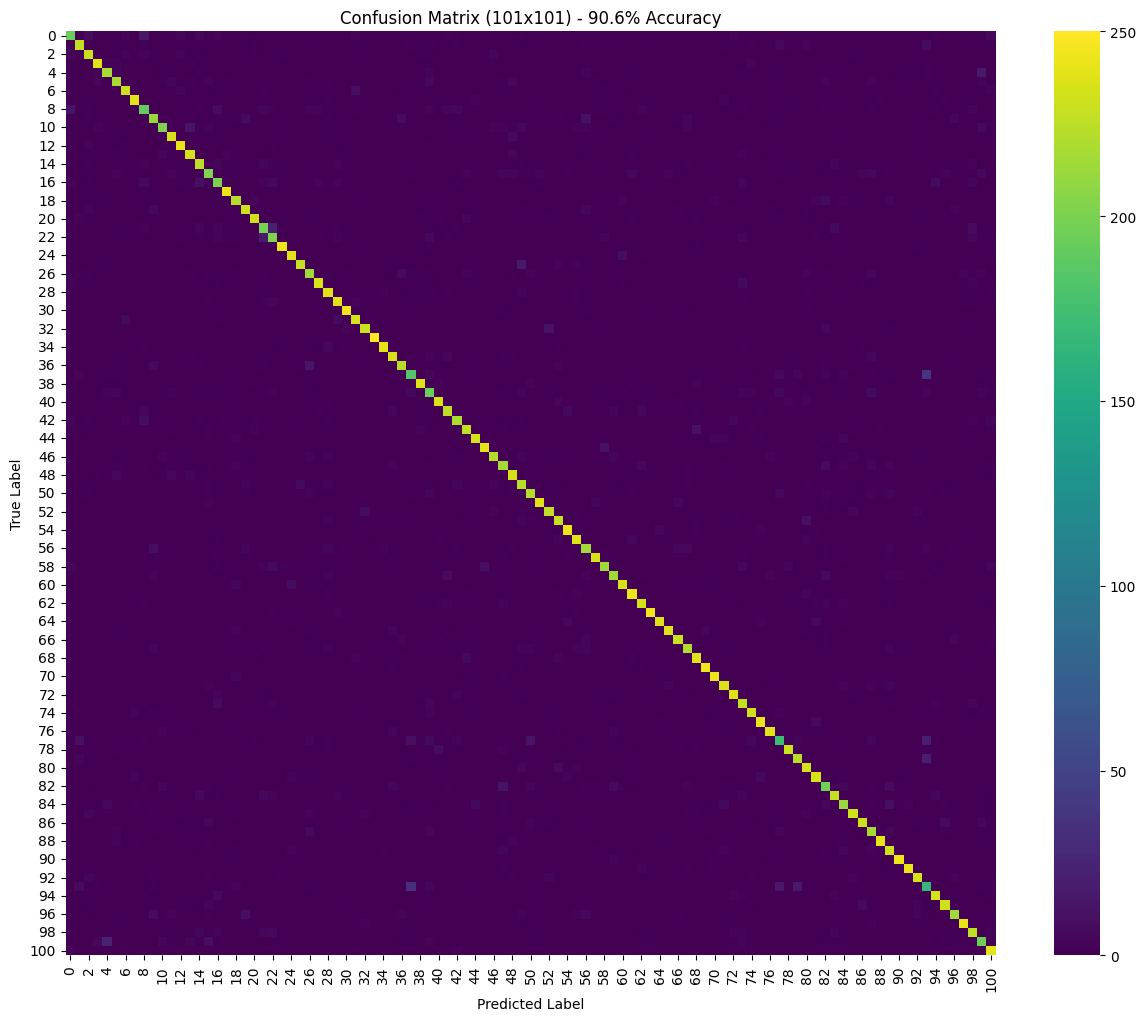

Note on Confusion Matrix: A 101x101 matrix is too large to see individual labels.
The bright diagonal line shows that the vast majority of predictions (y_pred) 
correctly match the true labels (y_true). The darker spots off-diagonal 
represent the few areas of confusion.

  Generating Sample Predictions  

Reloading validation set to show original images...


Generating validation split: 0 examples [00:00, ? examples/s]

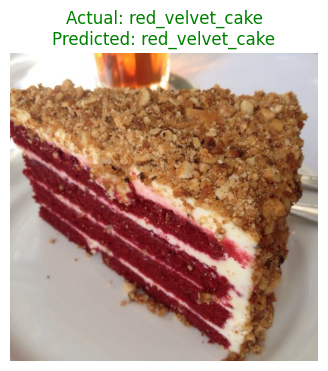

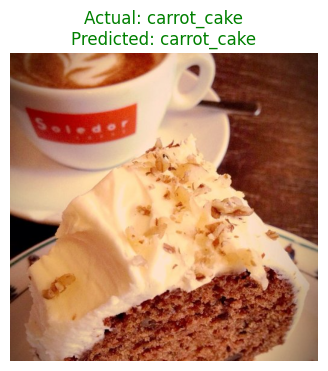

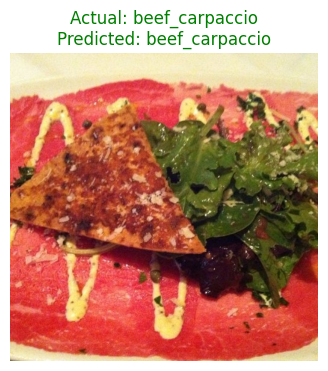

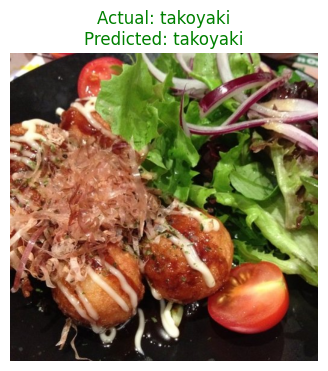

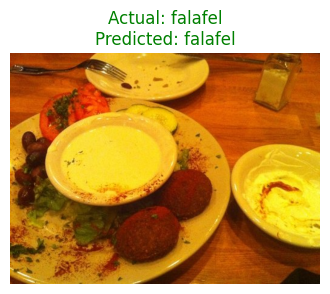

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image as PILImage
import random
import os

# --- 1. Get All Predictions (for Confusion Matrix) ---
# This will run the model over all 25,250 validation images.
print("Generating predictions for the entire validation set (25,250 images)...")
# Note: We use the 'validation' set, which we created from 'test.txt'
pred_output = trainer.predict(processed_datasets["validation"])

# The output contains predictions (logits), label_ids (true labels), and metrics
print("Predictions generated.")

# --- 2. Process Predictions ---
# The 'predictions' are the raw logits (a 25250 x 101 array)
# We take the argmax to find the single highest-scoring class (the prediction)
y_pred = np.argmax(pred_output.predictions, axis=1)

# 'label_ids' are the true labels
y_true = pred_output.label_ids

# --- 3. Compute and Plot Confusion Matrix ---
print("Calculating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, cmap="viridis", cbar=True)
plt.title(f"Confusion Matrix (101x101) - 90.6% Accuracy")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(
    "Note on Confusion Matrix: A 101x101 matrix is too large to see individual labels.\n"
    "The bright diagonal line shows that the vast majority of predictions (y_pred) \n"
    "correctly match the true labels (y_true). The darker spots off-diagonal \n"
    "represent the few areas of confusion."
)

# --- 4. Show Sample Predictions (Qualitative Evaluation) ---
print("\n" + "="*30)
print("  Generating Sample Predictions  ")
print("="*30 + "\n")

# We'll re-load the 'val_transforms' so we can see the *original* images
# (Our dataset currently has .set_transform() active)
# We need to create a *new* dataset object to get the original text paths
print("Reloading validation set to show original images...")
val_file_list = load_dataset('text', data_files={'validation': TEST_FILE})['validation']

# Get 5 random image indices
num_samples = 5
random_indices = random.sample(range(len(val_file_list)), num_samples)

# Loop and display
for idx in random_indices:
    # 1. Get the image path and true label
    item = val_file_list[idx]
    image_path = os.path.join(IMAGE_DIR, item['text'] + '.jpg')
    true_label_name = item['text'].split('/')[0]
    
    # 2. Load and process the original image
    image = PILImage.open(image_path).convert("RGB")
    
    # We apply the validation transforms (no augmentation)
    # to prepare it for the model
    processed_image = val_transforms(image)
    
    # Add a batch dimension and send to GPU
    pixel_values = processed_image.unsqueeze(0).to(trainer.model.device)

    # 3. Get Model Prediction
    with torch.no_grad():
        outputs = trainer.model(pixel_values)
        logits = outputs.logits
    
    pred_label_id = logits.argmax(-1).item()
    pred_label_name = id2label[pred_label_id]
    
    # 4. Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(
        f"Actual: {true_label_name}\nPredicted: {pred_label_name}",
        color=("green" if true_label_name == pred_label_name else "red")
    )
    plt.axis("off")
    plt.show()